In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt

Original CNN Model

In [2]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_set, val_set = random_split(train_set, [40000, 10000])


100%|██████████| 170498071/170498071 [00:06<00:00, 27268395.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [28]:
import torch.nn as nn
import torch.nn.functional as F

class Cifar10_Model(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)



        # Dense Layers
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.bn7 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn8 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(p=0.5)



    def forward(self, x):
        # Convolutional Layers with Activations

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)





        # Dense Layers
        x = x.view(-1, 256 * 4 * 4)  # Flatten
        x = F.relu(self.bn7(self.fc1(x)))

        x = self.dropout(x)  # Dropout
        x = F.relu(self.bn8(self.fc2(x)))

        x = self.dropout(x)  # Dropout
        x = self.fc3(x)

        return x

In [12]:
import torch.optim as optim

In [11]:
def train_and_evaluate(lr, batch_size, train_set, val_set, test_set, epochs):

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)
    model = Cifar10_Model()  # Instantiate the model for each trial
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_correct = 0  # Track correct predictions for training set
        val_correct = 0

        # Training Phase
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)  # Accumulate loss
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()

        # Validation Phase
        model.eval()
        with torch.no_grad():  # Disable gradients for evaluation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)  # Accumulate loss
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()

        # Calculate average loss over the entire dataset
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)

        train_acc = 100.0 * train_correct / len(train_loader.dataset)
        val_acc = 100.0 * val_correct / len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Acc: {train_acc:.2f}%, Validation Acc: {val_acc:.2f}%')

    return model, train_losses, val_losses, train_accuracies, val_accuracies, test_loader



In [22]:
model, train_losses, val_losses, train_accuracies, val_accuracies, test_loader = train_and_evaluate(0.001, 64, train_set, val_set, test_set)

Epoch 1, Training Loss: 1.2194, Validation Loss: 0.8537, Training Acc: 59.86%, Validation Acc: 69.75%
Epoch 2, Training Loss: 0.7927, Validation Loss: 0.6971, Training Acc: 75.33%, Validation Acc: 75.51%
Epoch 3, Training Loss: 0.6301, Validation Loss: 0.5978, Training Acc: 81.00%, Validation Acc: 79.31%
Epoch 4, Training Loss: 0.5166, Validation Loss: 0.5612, Training Acc: 85.12%, Validation Acc: 80.49%
Epoch 5, Training Loss: 0.4200, Validation Loss: 0.5335, Training Acc: 88.33%, Validation Acc: 81.37%
Epoch 6, Training Loss: 0.3467, Validation Loss: 0.5374, Training Acc: 90.59%, Validation Acc: 82.38%
Epoch 7, Training Loss: 0.2790, Validation Loss: 0.5125, Training Acc: 93.19%, Validation Acc: 83.37%
Epoch 8, Training Loss: 0.2140, Validation Loss: 0.4999, Training Acc: 95.16%, Validation Acc: 83.86%
Epoch 9, Training Loss: 0.1717, Validation Loss: 0.5598, Training Acc: 96.29%, Validation Acc: 83.55%
Epoch 10, Training Loss: 0.1419, Validation Loss: 0.5822, Training Acc: 97.22%, Va

In [13]:
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies):
  plt.figure(figsize=(10, 5))  # Adjust figure size as needed
  plt.plot(train_losses, label='Training Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title('Training and Validation Loss')
  plt.show()

  # Accuracy Plot
  plt.figure(figsize=(10, 5))
  plt.plot(train_accuracies, label='Training Accuracy')
  plt.plot(val_accuracies, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.title('Training and Validation Accuracy')
  plt.show()

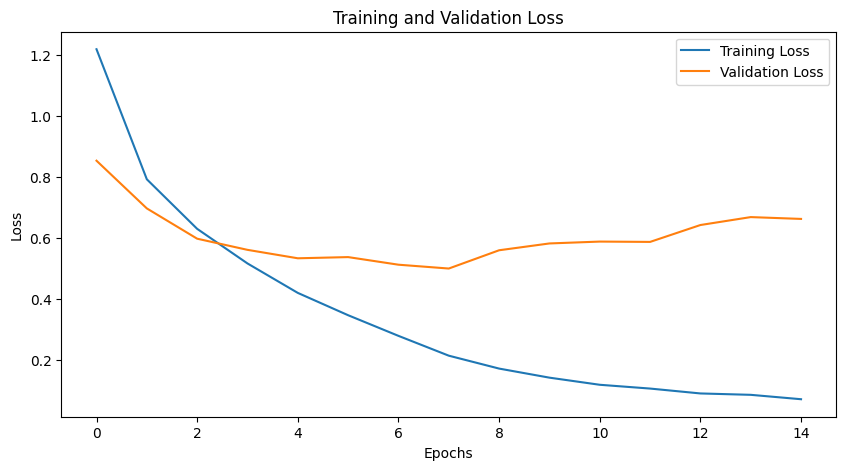

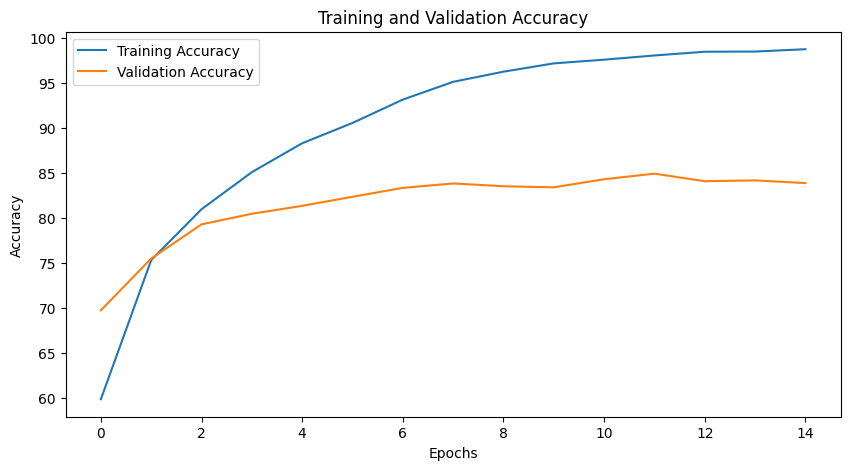

In [24]:
plot_results(train_losses, val_losses, train_accuracies, val_accuracies)

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [6]:
def evaluate_model(model, test_loader):
  target_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  model.eval()
  all_predictions = []
  all_labels = []

  with torch.no_grad():
      for images, labels in test_loader:
          device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
          model.to(device)
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)

          all_predictions.extend(predicted.cpu().numpy())  # Collect predictions as NumPy array
          all_labels.extend(labels.cpu().numpy())  # Collect labels as NumPy array


      # Confusion Matrix
      cm = confusion_matrix(all_labels, all_predictions)

      # Customize plot size
      length = 10
      fig_width = 8
      fig_height = 6
      plt.figure(figsize=(fig_width, fig_height))

      # Heatmap with Seaborn
      sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues')

      # Labels and title
      plt.xlabel("Predicted")
      plt.ylabel("Actual")

      plt.title("Confusion Matrix")
      plt.xticks(np.arange(len(target_names)) + 0.5, target_names, rotation=90)
      plt.yticks(np.arange(len(target_names)) + 0.5, target_names, rotation=0)
      plt.show()

      # Classification Report
      report = classification_report(all_labels, all_predictions, target_names=target_names)
      print("Classification Report:\n", report)

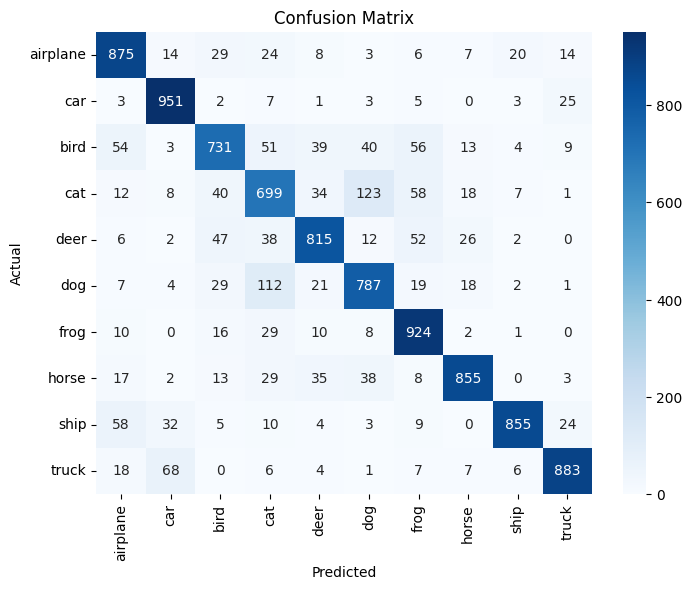

Classification Report:
               precision    recall  f1-score   support

    airplane       0.83      0.88      0.85      1000
         car       0.88      0.95      0.91      1000
        bird       0.80      0.73      0.76      1000
         cat       0.70      0.70      0.70      1000
        deer       0.84      0.81      0.83      1000
         dog       0.77      0.79      0.78      1000
        frog       0.81      0.92      0.86      1000
       horse       0.90      0.85      0.88      1000
        ship       0.95      0.85      0.90      1000
       truck       0.92      0.88      0.90      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [27]:
evaluate_model(model, test_loader)

In [28]:
torch.save(model, 'model.pth')

### Trying Data Augmentations

In [29]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_set, val_set = random_split(train_set, [40000, 10000])


Files already downloaded and verified
Files already downloaded and verified


In [32]:
model, train_losses, val_losses, train_accuracies, val_accuracies, test_loader = train_and_evaluate(0.001, 64, train_set, val_set, test_set, 15)

Epoch 1, Training Loss: 1.2567, Validation Loss: 0.9107, Training Acc: 58.55%, Validation Acc: 67.97%
Epoch 2, Training Loss: 0.8218, Validation Loss: 0.7075, Training Acc: 74.44%, Validation Acc: 75.67%
Epoch 3, Training Loss: 0.6656, Validation Loss: 0.6048, Training Acc: 80.05%, Validation Acc: 78.76%
Epoch 4, Training Loss: 0.5704, Validation Loss: 0.5383, Training Acc: 83.07%, Validation Acc: 81.70%
Epoch 5, Training Loss: 0.4971, Validation Loss: 0.5146, Training Acc: 85.46%, Validation Acc: 82.30%
Epoch 6, Training Loss: 0.4446, Validation Loss: 0.5193, Training Acc: 87.23%, Validation Acc: 82.60%
Epoch 7, Training Loss: 0.3973, Validation Loss: 0.4773, Training Acc: 89.17%, Validation Acc: 83.97%
Epoch 8, Training Loss: 0.3542, Validation Loss: 0.4702, Training Acc: 90.43%, Validation Acc: 84.32%
Epoch 9, Training Loss: 0.3170, Validation Loss: 0.4518, Training Acc: 91.67%, Validation Acc: 85.35%
Epoch 10, Training Loss: 0.2814, Validation Loss: 0.4673, Training Acc: 92.75%, Va

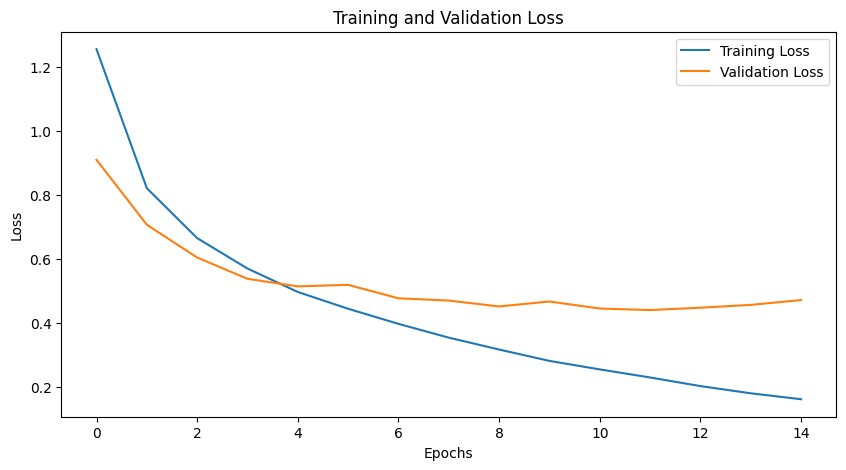

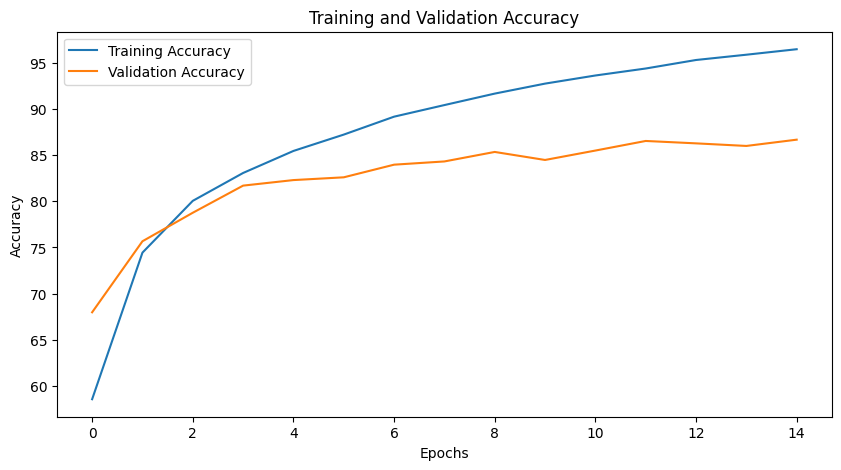

In [33]:
plot_results(train_losses, val_losses, train_accuracies, val_accuracies)

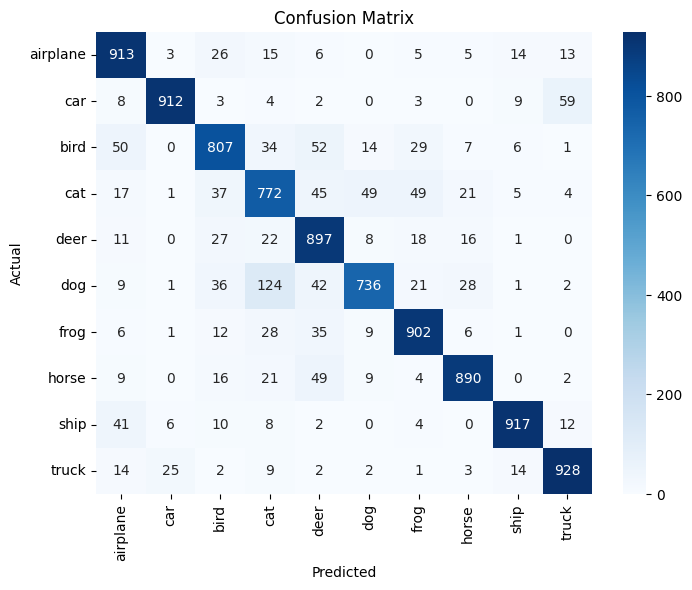

Classification Report:
               precision    recall  f1-score   support

    airplane       0.85      0.91      0.88      1000
         car       0.96      0.91      0.94      1000
        bird       0.83      0.81      0.82      1000
         cat       0.74      0.77      0.76      1000
        deer       0.79      0.90      0.84      1000
         dog       0.89      0.74      0.81      1000
        frog       0.87      0.90      0.89      1000
       horse       0.91      0.89      0.90      1000
        ship       0.95      0.92      0.93      1000
       truck       0.91      0.93      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [34]:
evaluate_model(model, test_loader)

In [35]:
torch.save(model, 'model2.pth')

### Hyperparamater Tuning with Random Search

In [19]:
import torch.optim as optim
import random

In [36]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_set, val_set = random_split(train_set, [40000, 10000])

Files already downloaded and verified
Files already downloaded and verified


In [22]:
num_trials = 20  # Number of random trials
for i in range(num_trials):
    lr = random.uniform(0.0001, 0.01)  # Random learning rate
    batch_size = random.choice([32, 64, 128])  # Random batch size

    print(f'Trial with lr: {lr}, batch_size: {batch_size} started.')
    train_and_evaluate(lr, batch_size, train_set, val_set, test_set, 15)
    print(f'Trial with lr: {lr}, batch_size: {batch_size} completed.')

Trial with lr: 0.00021205481780293796, batch_size: 32 started.
Epoch 1, Training Loss: 1.3091, Validation Loss: 0.9241, Training Acc: 55.76%, Validation Acc: 67.52%
Epoch 2, Training Loss: 0.8800, Validation Loss: 0.7507, Training Acc: 71.77%, Validation Acc: 73.58%
Epoch 3, Training Loss: 0.7176, Validation Loss: 0.6302, Training Acc: 77.75%, Validation Acc: 78.16%
Epoch 4, Training Loss: 0.6225, Validation Loss: 0.6432, Training Acc: 81.39%, Validation Acc: 78.13%
Epoch 5, Training Loss: 0.5433, Validation Loss: 0.5531, Training Acc: 84.13%, Validation Acc: 80.97%
Epoch 6, Training Loss: 0.4859, Validation Loss: 0.5120, Training Acc: 86.08%, Validation Acc: 82.13%
Epoch 7, Training Loss: 0.4339, Validation Loss: 0.5067, Training Acc: 87.91%, Validation Acc: 82.94%
Epoch 8, Training Loss: 0.3905, Validation Loss: 0.4931, Training Acc: 89.63%, Validation Acc: 83.17%
Epoch 9, Training Loss: 0.3416, Validation Loss: 0.4742, Training Acc: 90.89%, Validation Acc: 83.91%
Epoch 10, Training 

In [42]:
model, train_losses, val_losses, train_accuracies, val_accuracies, test_loader = train_and_evaluate(0.0035, 32, train_set, val_set, test_set, 15)

Epoch 1, Training Loss: 1.2342, Validation Loss: 0.9183, Training Acc: 59.14%, Validation Acc: 67.74%
Epoch 2, Training Loss: 0.8149, Validation Loss: 0.7431, Training Acc: 74.36%, Validation Acc: 74.41%
Epoch 3, Training Loss: 0.6538, Validation Loss: 0.6010, Training Acc: 80.31%, Validation Acc: 79.45%
Epoch 4, Training Loss: 0.5308, Validation Loss: 0.5584, Training Acc: 84.35%, Validation Acc: 80.56%
Epoch 5, Training Loss: 0.4439, Validation Loss: 0.5068, Training Acc: 87.78%, Validation Acc: 82.91%
Epoch 6, Training Loss: 0.3561, Validation Loss: 0.4794, Training Acc: 90.55%, Validation Acc: 84.06%
Epoch 7, Training Loss: 0.2852, Validation Loss: 0.5036, Training Acc: 92.87%, Validation Acc: 83.68%
Epoch 8, Training Loss: 0.2290, Validation Loss: 0.5575, Training Acc: 94.75%, Validation Acc: 82.75%
Epoch 9, Training Loss: 0.1784, Validation Loss: 0.5342, Training Acc: 96.16%, Validation Acc: 83.93%
Epoch 10, Training Loss: 0.1505, Validation Loss: 0.5632, Training Acc: 97.06%, Va

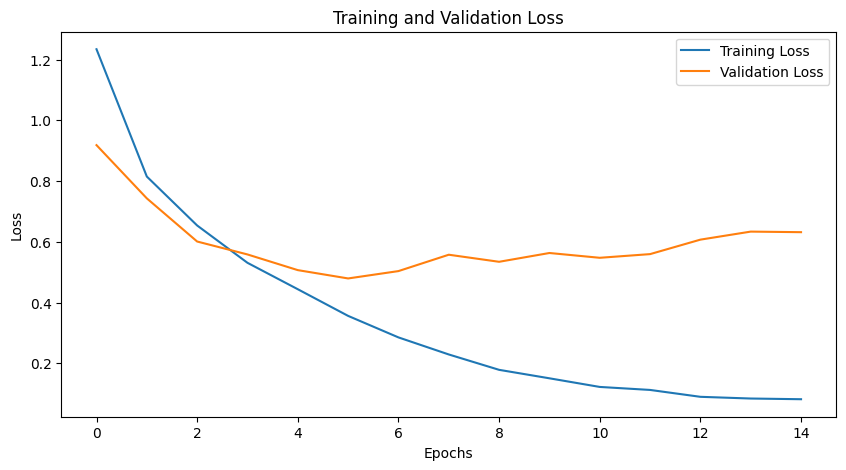

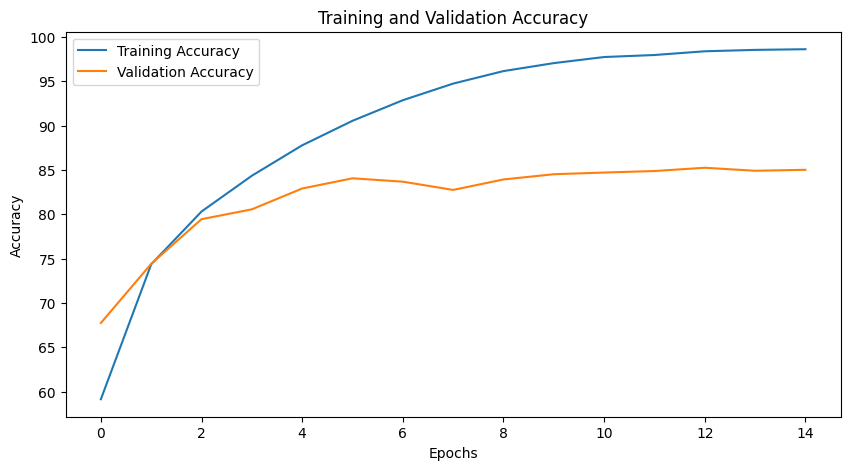

In [43]:
plot_results(train_losses, val_losses, train_accuracies, val_accuracies)

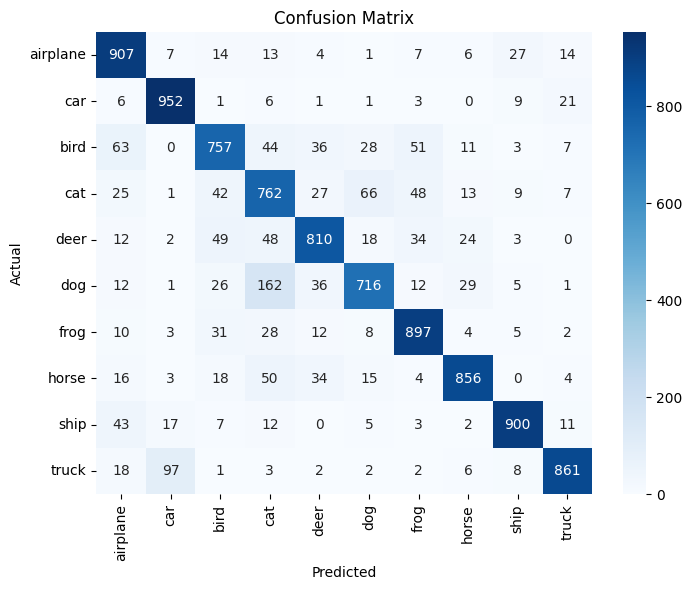

Classification Report:
               precision    recall  f1-score   support

    airplane       0.82      0.91      0.86      1000
         car       0.88      0.95      0.91      1000
        bird       0.80      0.76      0.78      1000
         cat       0.68      0.76      0.72      1000
        deer       0.84      0.81      0.83      1000
         dog       0.83      0.72      0.77      1000
        frog       0.85      0.90      0.87      1000
       horse       0.90      0.86      0.88      1000
        ship       0.93      0.90      0.91      1000
       truck       0.93      0.86      0.89      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



In [44]:
evaluate_model(model, test_loader)

In [17]:
def train_and_evaluate_new(lr, batch_size, train_set, val_set, test_set, epochs, model):

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)
    model = model  # Instantiate the model for each trial
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_correct = 0  # Track correct predictions for training set
        val_correct = 0

        # Training Phase
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)  # Accumulate loss
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()

        # Validation Phase
        model.eval()
        with torch.no_grad():  # Disable gradients for evaluation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)  # Accumulate loss
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()

        # Calculate average loss over the entire dataset
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)

        train_acc = 100.0 * train_correct / len(train_loader.dataset)
        val_acc = 100.0 * val_correct / len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Acc: {train_acc:.2f}%, Validation Acc: {val_acc:.2f}%')

    return model, train_losses, val_losses, train_accuracies, val_accuracies, test_loader



Reducing LR on Plateu Scheduler

In [47]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_set, val_set = random_split(train_set, [40000, 10000])

Files already downloaded and verified
Files already downloaded and verified


In [50]:
def train_and_evaluate_new2(lr, batch_size, train_set, val_set, test_set, epochs):

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)
    model = Cifar10_Model()  # Instantiate the model for each trial
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=1, verbose=True)

    for epoch in range(epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_correct = 0  # Track correct predictions for training set
        val_correct = 0

        # Training Phase
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)  # Accumulate loss
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()

        # Validation Phase
        model.eval()
        with torch.no_grad():  # Disable gradients for evaluation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)  # Accumulate loss
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()

        # Calculate average loss over the entire dataset
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)

        train_acc = 100.0 * train_correct / len(train_loader.dataset)
        val_acc = 100.0 * val_correct / len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Acc: {train_acc:.2f}%, Validation Acc: {val_acc:.2f}%')

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

    return model, train_losses, val_losses, train_accuracies, val_accuracies, test_loader


In [48]:
model, train_losses, val_losses, train_accuracies, val_accuracies, test_loader = train_and_evaluate_new2(0.001, 64, train_set, val_set, test_set, epochs=15)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Training Loss: 1.2181, Validation Loss: 0.8976, Training Acc: 59.84%, Validation Acc: 68.17%
Epoch 2, Training Loss: 0.7880, Validation Loss: 0.6925, Training Acc: 75.47%, Validation Acc: 75.59%
Epoch 3, Training Loss: 0.6362, Validation Loss: 0.5861, Training Acc: 81.01%, Validation Acc: 79.58%
Epoch 4, Training Loss: 0.5214, Validation Loss: 0.5795, Training Acc: 84.90%, Validation Acc: 80.04%
Epoch 5, Training Loss: 0.4288, Validation Loss: 0.5578, Training Acc: 88.24%, Validation Acc: 81.22%
Epoch 6, Training Loss: 0.3500, Validation Loss: 0.5288, Training Acc: 90.78%, Validation Acc: 82.60%
Epoch 7, Training Loss: 0.2768, Validation Loss: 0.5060, Training Acc: 93.07%, Validation Acc: 83.57%
Epoch 8, Training Loss: 0.2208, Validation Loss: 0.5473, Training Acc: 94.85%, Validation Acc: 83.21%
Epoch 9, Training Loss: 0.1760, Validation Loss: 0.5679, Training Acc: 96.24%, Validation Acc: 83.71%
Epoch 10, Training Loss: 0.0702, Validation Loss: 0.4844, Training Acc: 98.06%, Va

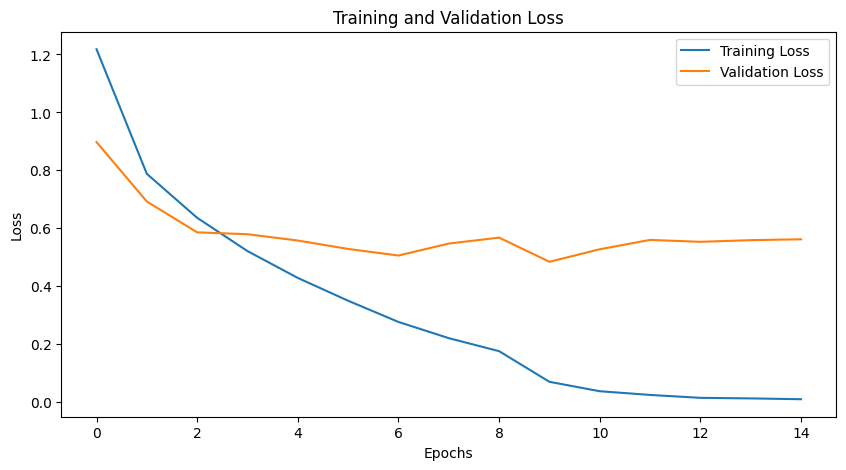

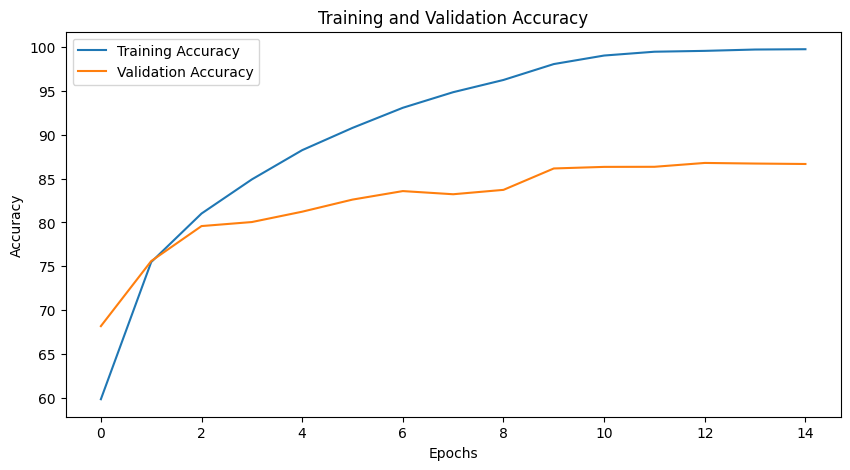

In [49]:
plot_results(train_losses, val_losses, train_accuracies, val_accuracies)

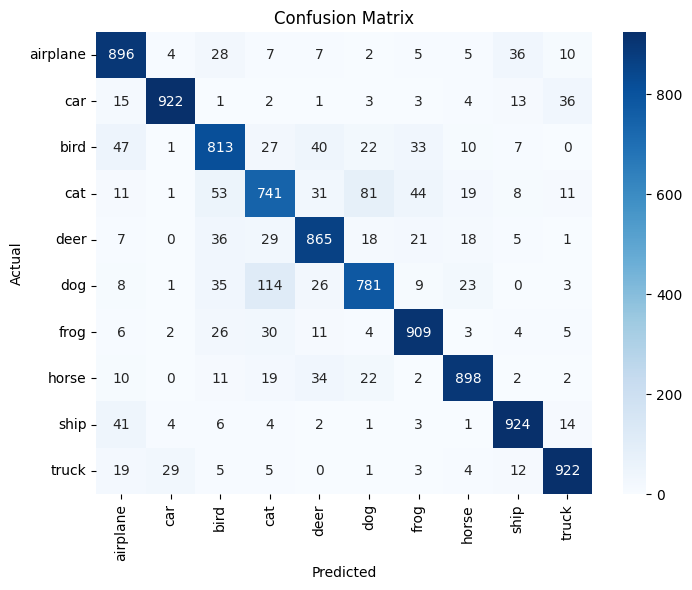

Classification Report:
               precision    recall  f1-score   support

    airplane       0.85      0.90      0.87      1000
         car       0.96      0.92      0.94      1000
        bird       0.80      0.81      0.81      1000
         cat       0.76      0.74      0.75      1000
        deer       0.85      0.86      0.86      1000
         dog       0.84      0.78      0.81      1000
        frog       0.88      0.91      0.89      1000
       horse       0.91      0.90      0.90      1000
        ship       0.91      0.92      0.92      1000
       truck       0.92      0.92      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [51]:
evaluate_model(model, test_loader)

Final Implementation

In [19]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip horizontally
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_set, val_set = random_split(train_set, [40000, 10000])


Files already downloaded and verified
Files already downloaded and verified


In [37]:
def train_and_evaluate_new2(lr, batch_size, train_set, val_set, test_set, epochs):

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)
    model = Cifar10_Model()  # Instantiate the model for each trial
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=1, verbose=True)

    for epoch in range(epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_correct = 0  # Track correct predictions for training set
        val_correct = 0

        # Training Phase
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)  # Accumulate loss
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()

        # Validation Phase
        model.eval()
        with torch.no_grad():  # Disable gradients for evaluation
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)  # Accumulate loss
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()

        # Calculate average loss over the entire dataset
        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)

        train_acc = 100.0 * train_correct / len(train_loader.dataset)
        val_acc = 100.0 * val_correct / len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Training Acc: {train_acc:.2f}%, Validation Acc: {val_acc:.2f}%')

        # Adjust learning rate based on validation loss
        scheduler.step(val_loss)

    return model, train_losses, val_losses, train_accuracies, val_accuracies, test_loader


In [35]:
model, train_losses, val_losses, train_accuracies, val_accuracies, test_loader = train_and_evaluate(0.001, 64, train_set, val_set, test_set, epochs=15)

Epoch 1, Training Loss: 1.2428, Validation Loss: 0.8975, Training Acc: 59.06%, Validation Acc: 67.64%
Epoch 2, Training Loss: 0.8245, Validation Loss: 0.7237, Training Acc: 74.16%, Validation Acc: 74.60%
Epoch 3, Training Loss: 0.6779, Validation Loss: 0.6208, Training Acc: 79.37%, Validation Acc: 77.86%
Epoch 4, Training Loss: 0.5849, Validation Loss: 0.5579, Training Acc: 82.57%, Validation Acc: 80.55%
Epoch 5, Training Loss: 0.5097, Validation Loss: 0.5096, Training Acc: 85.17%, Validation Acc: 82.28%
Epoch 6, Training Loss: 0.4604, Validation Loss: 0.5102, Training Acc: 86.90%, Validation Acc: 82.28%
Epoch 7, Training Loss: 0.4037, Validation Loss: 0.4613, Training Acc: 88.85%, Validation Acc: 84.03%
Epoch 8, Training Loss: 0.3657, Validation Loss: 0.4537, Training Acc: 90.02%, Validation Acc: 84.77%
Epoch 9, Training Loss: 0.3232, Validation Loss: 0.4262, Training Acc: 91.30%, Validation Acc: 85.62%
Epoch 10, Training Loss: 0.2858, Validation Loss: 0.4144, Training Acc: 92.55%, Va

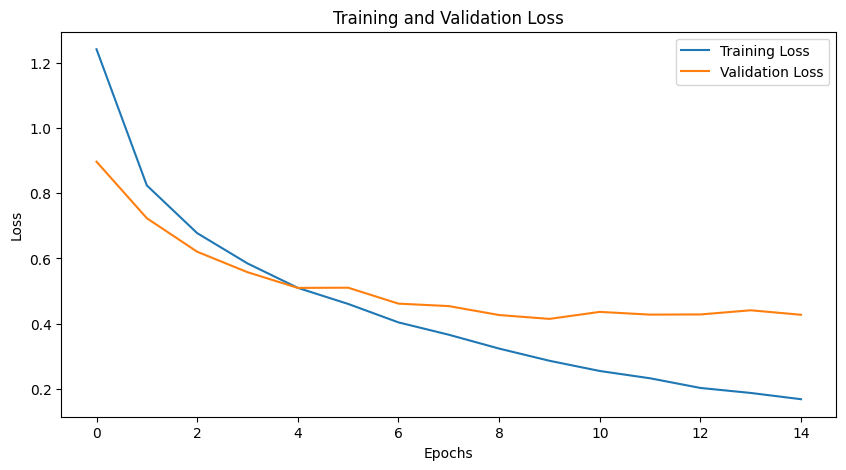

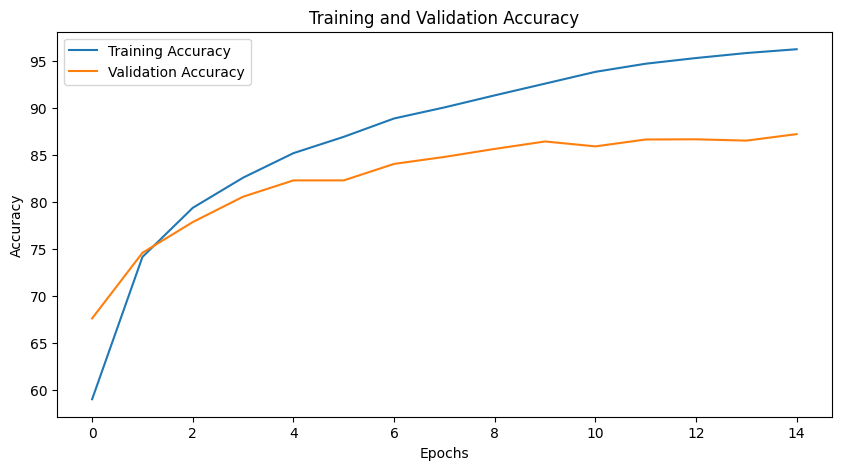

In [39]:
plot_results(train_losses, val_losses, train_accuracies, val_accuracies)

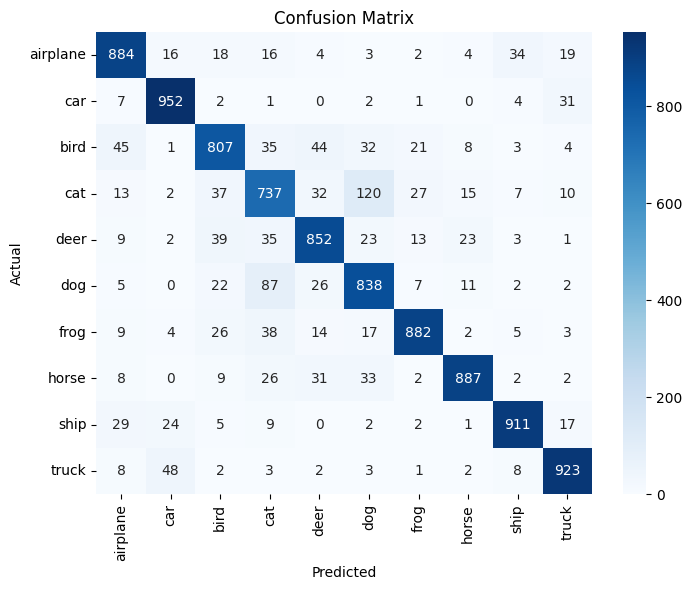

Classification Report:
               precision    recall  f1-score   support

    airplane       0.87      0.88      0.88      1000
         car       0.91      0.95      0.93      1000
        bird       0.83      0.81      0.82      1000
         cat       0.75      0.74      0.74      1000
        deer       0.85      0.85      0.85      1000
         dog       0.78      0.84      0.81      1000
        frog       0.92      0.88      0.90      1000
       horse       0.93      0.89      0.91      1000
        ship       0.93      0.91      0.92      1000
       truck       0.91      0.92      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [40]:
evaluate_model(model, test_loader)

In [41]:
model2, train_losses, val_losses, train_accuracies, val_accuracies, test_loader2 = train_and_evaluate_new2(0.001, 64, train_set, val_set, test_set, epochs=15)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1, Training Loss: 1.2645, Validation Loss: 1.0094, Training Acc: 58.40%, Validation Acc: 64.07%
Epoch 2, Training Loss: 0.8315, Validation Loss: 0.7806, Training Acc: 73.93%, Validation Acc: 72.62%
Epoch 3, Training Loss: 0.6872, Validation Loss: 0.5943, Training Acc: 79.20%, Validation Acc: 79.33%
Epoch 4, Training Loss: 0.5927, Validation Loss: 0.5470, Training Acc: 82.42%, Validation Acc: 81.29%
Epoch 5, Training Loss: 0.5167, Validation Loss: 0.5202, Training Acc: 85.12%, Validation Acc: 81.89%
Epoch 6, Training Loss: 0.4619, Validation Loss: 0.4782, Training Acc: 86.81%, Validation Acc: 84.16%
Epoch 7, Training Loss: 0.4031, Validation Loss: 0.4583, Training Acc: 88.70%, Validation Acc: 83.95%
Epoch 8, Training Loss: 0.3610, Validation Loss: 0.4412, Training Acc: 90.08%, Validation Acc: 84.88%
Epoch 9, Training Loss: 0.3250, Validation Loss: 0.4222, Training Acc: 91.31%, Validation Acc: 85.71%
Epoch 10, Training Loss: 0.2914, Validation Loss: 0.4352, Training Acc: 92.61%, Va

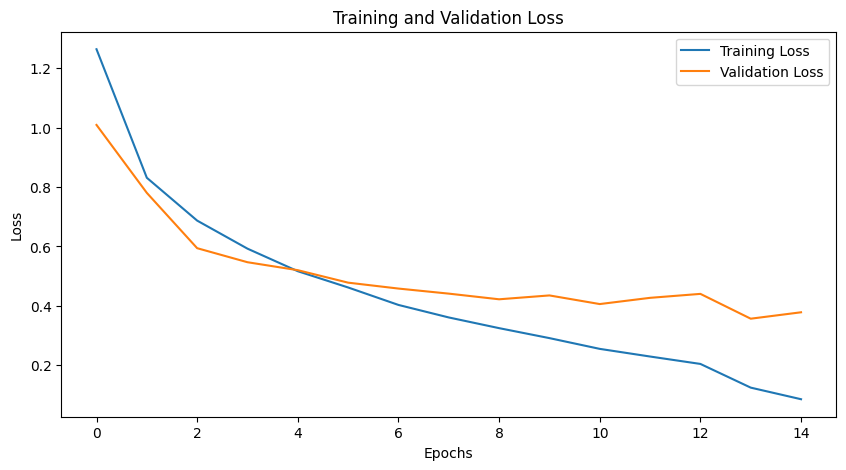

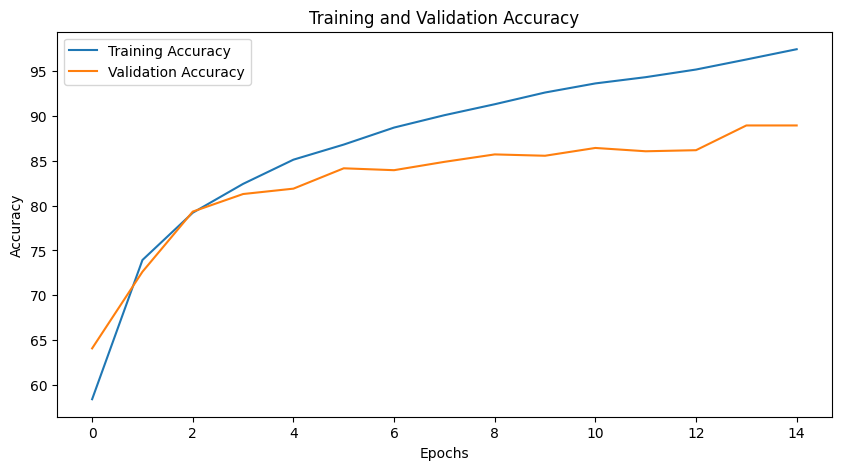

In [42]:
plot_results(train_losses, val_losses, train_accuracies, val_accuracies)

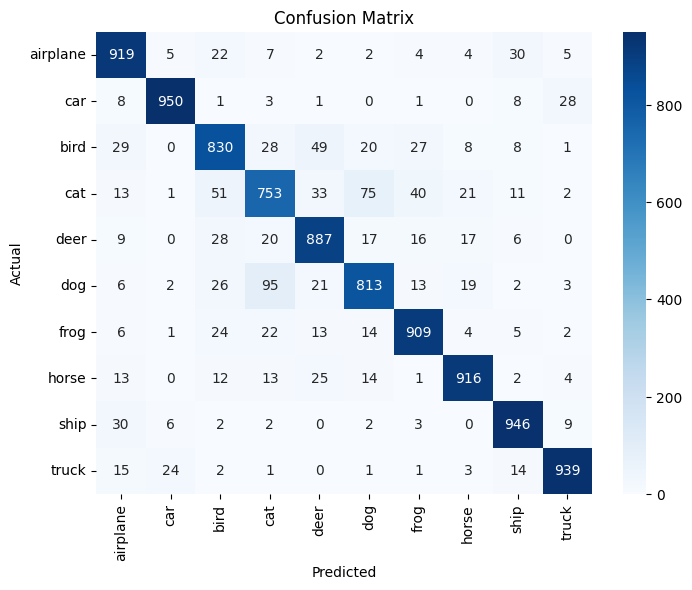

Classification Report:
               precision    recall  f1-score   support

    airplane       0.88      0.92      0.90      1000
         car       0.96      0.95      0.96      1000
        bird       0.83      0.83      0.83      1000
         cat       0.80      0.75      0.77      1000
        deer       0.86      0.89      0.87      1000
         dog       0.85      0.81      0.83      1000
        frog       0.90      0.91      0.90      1000
       horse       0.92      0.92      0.92      1000
        ship       0.92      0.95      0.93      1000
       truck       0.95      0.94      0.94      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [44]:
evaluate_model(model2, test_loader2)

In [52]:
torch.save(model2, 'bestmodel.pth')